In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from wing import WingsOfEvidence
from sklearn.metrics import fbeta_score
from pdpbox import pdp, get_dataset, info_plots

In [35]:
def get_info_start(frame):
    """
    Процедура выводит краткую информацию о переданной таблице
    """
    # Размер таблицы
    print("Размеры данных: ",frame.shape)
    # Имена столбцов
    print("Имена столбцов: ",frame.columns.values)
    # Отображение первых пяти строк таблицы
    display(frame.head())
    
def removing_outliers(column,frame, count = 0,total_outliers = 0):
        """
        Метод удаления выбросов с помощью межквартильного размаха
        """
        # Получим квантиль 25%
        q25=np.array(frame[column].describe(percentiles=[.25,.75]).loc['25%'])
        # Получим квантиль 75%
        q75=np.array(frame[column].describe(percentiles=[.25,.75]).loc['75%'])
        # Получим первую границу
        first_part=q25-3*(q75-q25)
        # Получим 2 границу
        second_part=q75+3*(q75-q25)
        # Инициализируем список для индексов, подготовленных к удалению
        index_del= []
        # Переберем все значения и проверим на принадлежность к установленному отрезку
        for index, element in enumerate(frame[column]):
            if first_part > element or second_part< element:
                index_del.extend(frame[frame[column] == element].index)
        index_del= list(set(index_del))
        leng = len(index_del)
        count += 1
        
        # Удалим выбранные индексы
        frame = frame.drop(index_del,axis=0)
        if leng > 0:
            frame,leng,total_outliers = removing_outliers(column,frame, count,total_outliers+leng)
        else:
            print('Количество строк, выбранных для удаления {}: {}. Количество итераций {}'.format(column,total_outliers,count),end = "\n\n")
        return frame,leng,total_outliers

def best_threshold(target_vector,predictions,model_name,beta = 1):
    # Первичное получение данных метрики ROC-кривой
    fpr, tpr, thresholds = roc_curve(np.array(target_vector), predictions, pos_label=1)
    best_accuracy = 0
    best_f1 = 0
    best_threshold = -1
    best_threshold_f1 = -1
    #Найдем площадь под кривой
    auc_value = round(auc(fpr,tpr),2)
    
    #Если площадь будеть меньше 0.5, это означает, что нужно нужно вычесть каждую вероятность из 1
    if auc_value < 0.5:
        predictions = 1 - predictions
        fpr, tpr, thresholds = roc_curve(np.array(target_vector), predictions, pos_label=1)
        auc_value = round(auc(fpr,tpr),2)
        
    # переберем все пороги в поисках наилучшей точности
    for threshold in thresholds:
        pre_marker = np.array(predictions > threshold)
        accuracy = accuracy_score(target_vector,pre_marker)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    for threshold in thresholds:
        pre_marker = np.array(predictions > threshold)
        f1_threshold = fbeta_score(target_vector,pre_marker,beta)
        if f1_threshold > best_f1:
            best_f1 = f1_threshold
            best_threshold_f1 = threshold
            
    #Построим ROC-кривую
    fig,ax = plt.subplots(figsize= (10,5))
    ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label = 'BaseLine',ls = '--')
    ax.plot(fpr,
            tpr,
            label = f"{model_name} (area = {auc_value}, best_accuracy = {best_accuracy}, best_fbeta = {best_f1},beta = {beta})")
    ax.legend()
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    print("Best f1: {}, threshold: {}".format(best_f1,best_threshold_f1))
    print("Best accuracy: {}, threshold: {}".format(best_accuracy,best_threshold))

    
    

# Загрузка данных

In [102]:
frame = pd.read_csv("bank-additional-full.csv",sep=';')

In [103]:
frame.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [104]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [105]:
frame['target'] = frame['y'].apply(lambda x: 1 if x=='yes' else 0)

In [106]:
frame = frame.drop(['y'],axis = 1)

# Анализ загруженных данных

In [107]:
frame.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [108]:
numeric_labels = list(frame.select_dtypes([np.number]).columns[:-1])
numeric_labels.remove('euribor3m')
numeric_labels.remove('age')
numeric_labels.remove('previous')

In [109]:
numeric_labels

['duration',
 'campaign',
 'pdays',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed']

In [110]:
# for label in numeric_labels:
#     frame,_,_ = removing_outliers(label,frame)

In [111]:
frame.shape

(41188, 21)

## Предсказание без обработки фичей

In [112]:
frame['target'].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: target, dtype: float64

In [113]:
frame = pd.get_dummies(frame)

In [114]:
(design_train,
 design_test,
 target_train,
 target_test) = train_test_split(frame.drop(["target"],axis = 1),frame["target"],random_state = 42, test_size = 0.2)

(design_valid,
 design_test,
 target_valid,
 target_test) = train_test_split(design_test, target_test, random_state = 42, test_size = 0.5)

In [115]:
steps = [('smote',SMOTE()),('stand',StandardScaler()), ('model', RandomForestClassifier(n_jobs=-1,
                                                            n_estimators=1000,max_depth=10))]
RF = Pipeline(steps=steps)

In [116]:
RF.fit(design_train,target_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('stand',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,


In [117]:
RF_valid_pred = RF.predict(design_valid)
predictions_RandomForest = RF.predict_proba(design_valid)

In [118]:
f1_score(target_valid,RF_valid_pred)

0.58125

Best f1: 0.7525555163905534, threshold: 0.31052155982030355
Best accuracy: 0.9089584850691915, threshold: 0.6544764976437034


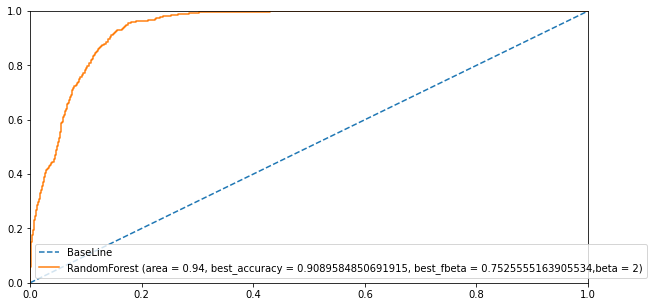

In [122]:
best_threshold(target_valid,predictions_RandomForest[:,1],"RandomForest",beta = 2)

In [123]:

new_RF_preds = [1 if i >= 0.31052155982030355 else 0 for i in predictions_RandomForest[:,1] ]

In [124]:
confusion_matrix(target_valid,new_RF_preds)

array([[3094,  563],
       [  35,  427]], dtype=int64)

In [ ]:
# frame = pd.get_dummies(frame)
# (design_train,
#  design_test,
#  target_train,
#  target_test) = train_test_split(frame.drop(["target"],axis = 1),frame["target"],random_state = 42, test_size = 0.2)

# (design_valid,
#  design_test,
#  target_valid,
#  target_test) = train_test_split(design_test, target_test, random_state = 42, test_size = 0.5)
# steps = [('smote',SMOTE()),('stand',StandardScaler()), ('model', RandomForestClassifier(n_jobs=-1,
#                                                             n_estimators=1000,max_depth=10))]
# RF = Pipeline(steps=steps)
# RF.fit(design_train,target_train)
# RF_valid_pred = RF.predict(design_valid)
# predictions_RandomForest = RF.predict_proba(design_valid)
# f1_score(target_valid,RF_valid_pred)